In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, roc_curve

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'
plt.rcParams.update({
    'text.usetex':False,
    'font.family':'monospace'
})  
import seaborn as sns

import optuna
from xgboost import XGBClassifier

Bootstrapping to find the confidence intervals for the AUROC score

In [3]:
def bootstrap_auc_ci(y_true, y_scores, n_bootstraps=2000, ci=0.95):
    rng = np.random.default_rng(42)
    aucs = []

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    for _ in range(n_bootstraps):
        idx = rng.integers(0, len(y_true), len(y_true))
        if len(np.unique(y_true[idx])) < 2:
            continue
        aucs.append(roc_auc_score(y_true[idx], y_scores[idx]))

    lower = np.percentile(aucs, (1 - ci) / 2 * 100)
    upper = np.percentile(aucs, (1 + ci) / 2 * 100)
    return np.mean(aucs), lower, upper

Loading the dataset, pre-processing, and analysing the data

In [4]:
cohort_data = pd.read_csv('../cohort_data_new.csv')
cohort_data

,icustay_id,anion_gap_mean,anion_gap_sd,anion_gap_min,anion_gap_max,bicarbonate_mean,bicarbonate_sd,bicarbonate_min,bicarbonate_max,calcium_total_mean,...,urea_nitrogen_min,urea_nitrogen_max,white_blood_cells_mean,white_blood_cells_sd,white_blood_cells_min,white_blood_cells_max,age,gender,icu_los_hours,target
0,200003,13.375000,3.583195,9.0,21.0,25.250000,3.105295,18.0,28.0,7.771429,...,10.0,21.0,26.471429,13.176711,13.2,43.9,48,M,141,0
1,200007,15.500000,2.121320,14.0,17.0,23.000000,1.414214,22.0,24.0,8.900000,...,8.0,10.0,10.300000,1.272792,9.4,11.2,44,M,30,0
2,200009,9.500000,2.121320,8.0,11.0,23.333333,2.081666,21.0,25.0,8.000000,...,15.0,21.0,12.471429,1.471637,10.5,14.3,47,F,51,0
3,200012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.900000,NaN,4.9,4.9,33,F,10,0
4,200014,10.000000,1.732051,9.0,12.0,24.000000,1.000000,23.0,25.0,7.733333,...,21.0,24.0,13.233333,2.203028,10.7,14.7,85,M,41,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30484,299992,15.375000,2.856153,11.0,25.0,23.125000,2.609556,15.0,26.0,8.307143,...,8.0,23.0,14.134783,3.781727,8.1,22.1,41,M,499,0
30485,299993,9.400000,1.341641,8.0,11.0,29.600000,2.073644,26.0,31.0,8.000000,...,12.0,15.0,12.600000,0.605530,12.0,13.3,26,M,67,0
30486,299994,16.157895,2.477973,13.0,24.0,21.631579,3.451417,17.0,31.0,8.100000,...,28.0,63.0,10.076190,2.642329,5.3,14.5,74,F,152,1
30487,299998,11.500000,1.732051,10.0,14.0,23.500000,1.290994,22.0,25.0,8.800000,...,20.0,22.0,9.900000,1.210372,7.9,11.0,87,M,46,1


In [5]:
# REmove the ICUstay_id and the gender
drop_cols = [c for c in cohort_data.columns if 'icustay_id' in c.lower() or 'gender' in c.lower()]
df = cohort_data.drop(columns=['icustay_id', 'gender'], errors='ignore')

X = df.drop(columns=['target'])
y = df['target']

# Keep only numeric
X = X.select_dtypes(include=['number']).replace([np.inf, -np.inf], np.nan)

print(f"Final feature matrix shape: {X.shape}")

Final feature matrix shape: (30489, 90)


In [7]:
# Test-Train split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=7)
print(f"Train Full: {X_train_full.shape}, Test: {X_test.shape}")

# Train-Dev split for 
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, stratify=y_train_full, random_state=7)

print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_val))
print(np.shape(y_val))
print(np.shape(X_test))
print(np.shape(y_test))

print(f'# Readmissions in Train: {np.sum(y_train)}')
print(f'# Readmissions in Validation: {np.sum(y_val)}')
print(f'# Readmissions in Test: {np.sum(y_test) }')
print(f'% Readmissions in Train: {np.mean(y_train) * 100}')
print(f'% Readmissions in Validation: {np.mean(y_val) * 100}')
print(f'% Readmissions in Test: {np.mean(y_test) * 100}')
print(f'Total: {np.sum(y), np.mean(y)*100}')

Train Full: (21342, 90), Test: (9147, 90)
(14939, 90)
(14939,)
(6403, 90)
(6403,)
(9147, 90)
(9147,)
# Readmissions in Train: 1605
# Readmissions in Validation: 688
# Readmissions in Test: 983
% Readmissions in Train: 10.74369101010777
% Readmissions in Validation: 10.74496329845385
% Readmissions in Test: 10.746692904777523
Total: (np.int64(3276), np.float64(10.74485880153498))


In [8]:
def objective(trial):
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, stratify=y_train_full, random_state=7)

    # Handle imbalance
    scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])

    params = {
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
        "max_depth": trial.suggest_int("max_depth", 3, 25),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 15),
        "gamma": trial.suggest_float("gamma", 0.0, 1.0),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 2.0),
        "n_estimators": trial.suggest_int("n_estimators", 300, 5000),
        "max_delta_step": trial.suggest_int("max_delta_step", 0, 10),
        "scale_pos_weight": scale_pos_weight,
        "random_state": 42,
        "eval_metric": "auc",
        "tree_method": "hist",
        "use_label_encoder": False
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    y_val_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred)

    return auc

Hyperparameters

In [9]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25, show_progress_bar=True)

print("Search for hyperparameters complete:")
print(study.best_params)

[I 2025-11-30 16:01:25,678] A new study created in memory with name: no-name-335872b6-e99b-4b17-968f-9be2842c9a6f


  0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\risha\AppData\Local\Temp\ipykernel_30804\2393891905.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:01:25] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 16:01:37,380] Trial 0 finished with value: 0.6921511627906977 and parameters: {'learning_rate': 0.057257333190652855, 'max_depth': 20, 'min_child_weight': 8, 'gamma': 0.4443368675606463, 'subsample': 0.9380625997628103, 'colsample_bytree': 0.5702182963564397, 'reg_alpha': 0.258696565047326, 'reg_lambda': 0.4151775645476101, 'n_estimators': 2042, 'max_delta_step': 6}. Best is trial 0 with value: 0.6921511627906977.


C:\Users\risha\AppData\Local\Temp\ipykernel_30804\2393891905.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:01:37] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 16:02:54,135] Trial 1 finished with value: 0.7052595169789821 and parameters: {'learning_rate': 0.0017220905967966066, 'max_depth': 21, 'min_child_weight': 15, 'gamma': 0.6478335893167172, 'subsample': 0.4279180935654048, 'colsample_bytree': 0.9627550803471924, 'reg_alpha': 0.326684783860687, 'reg_lambda': 1.4121630020283127, 'n_estimators': 4335, 'max_delta_step': 3}. Best is trial 1 with value: 0.7052595169789821.


C:\Users\risha\AppData\Local\Temp\ipykernel_30804\2393891905.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:02:54] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 16:04:45,144] Trial 2 finished with value: 0.701078862235244 and parameters: {'learning_rate': 0.003525352396213111, 'max_depth': 22, 'min_child_weight': 7, 'gamma': 0.7997078216021679, 'subsample': 0.9315818908391408, 'colsample_bytree': 0.9639076680238918, 'reg_alpha': 0.9701535032051728, 'reg_lambda': 1.8674905920203773, 'n_estimators': 3833, 'max_delta_step': 6}. Best is trial 1 with value: 0.7052595169789821.


C:\Users\risha\AppData\Local\Temp\ipykernel_30804\2393891905.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:04:45] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 16:04:50,545] Trial 3 finished with value: 0.6692989684428982 and parameters: {'learning_rate': 0.2874597282452235, 'max_depth': 11, 'min_child_weight': 5, 'gamma': 0.36982507431521283, 'subsample': 0.9626015618896764, 'colsample_bytree': 0.8726350747316993, 'reg_alpha': 0.3624561437045816, 'reg_lambda': 1.8781265557455231, 'n_estimators': 597, 'max_delta_step': 3}. Best is trial 1 with value: 0.7052595169789821.


C:\Users\risha\AppData\Local\Temp\ipykernel_30804\2393891905.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:04:50] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 16:05:42,632] Trial 4 finished with value: 0.6961803648090501 and parameters: {'learning_rate': 0.010762186444659108, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.6207606894747565, 'subsample': 0.9014415867749711, 'colsample_bytree': 0.8885750336643627, 'reg_alpha': 0.16764725793093477, 'reg_lambda': 0.864156335303532, 'n_estimators': 3360, 'max_delta_step': 9}. Best is trial 1 with value: 0.7052595169789821.


C:\Users\risha\AppData\Local\Temp\ipykernel_30804\2393891905.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:42] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 16:07:37,014] Trial 5 finished with value: 0.704732802295062 and parameters: {'learning_rate': 0.0012141852720386778, 'max_depth': 21, 'min_child_weight': 11, 'gamma': 0.9940886023672109, 'subsample': 0.5736339514959344, 'colsample_bytree': 0.7701023408581309, 'reg_alpha': 0.5882660645514702, 'reg_lambda': 1.333975943978165, 'n_estimators': 4334, 'max_delta_step': 0}. Best is trial 1 with value: 0.7052595169789821.


C:\Users\risha\AppData\Local\Temp\ipykernel_30804\2393891905.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:07:37] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 16:08:40,288] Trial 6 finished with value: 0.6939673238519604 and parameters: {'learning_rate': 0.015371374393341903, 'max_depth': 24, 'min_child_weight': 6, 'gamma': 0.48203023776765686, 'subsample': 0.5738369133861713, 'colsample_bytree': 0.6571438038758883, 'reg_alpha': 0.512064380662061, 'reg_lambda': 1.1067000342436966, 'n_estimators': 4533, 'max_delta_step': 7}. Best is trial 1 with value: 0.7052595169789821.


C:\Users\risha\AppData\Local\Temp\ipykernel_30804\2393891905.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:08:40] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 16:09:05,193] Trial 7 finished with value: 0.6985284542920507 and parameters: {'learning_rate': 0.0018996796798616937, 'max_depth': 20, 'min_child_weight': 11, 'gamma': 0.565144381772191, 'subsample': 0.6900959812859155, 'colsample_bytree': 0.7569725600057713, 'reg_alpha': 0.8395011519015525, 'reg_lambda': 1.9165094198996144, 'n_estimators': 553, 'max_delta_step': 5}. Best is trial 1 with value: 0.7052595169789821.


C:\Users\risha\AppData\Local\Temp\ipykernel_30804\2393891905.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:09:05] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 16:10:41,977] Trial 8 finished with value: 0.7015997273596614 and parameters: {'learning_rate': 0.004059830886806319, 'max_depth': 24, 'min_child_weight': 4, 'gamma': 0.8199261732110893, 'subsample': 0.42915729927225116, 'colsample_bytree': 0.8609569505983893, 'reg_alpha': 0.8530257668438872, 'reg_lambda': 0.2341270623665069, 'n_estimators': 1641, 'max_delta_step': 5}. Best is trial 1 with value: 0.7052595169789821.


C:\Users\risha\AppData\Local\Temp\ipykernel_30804\2393891905.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:10:42] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 16:10:56,010] Trial 9 finished with value: 0.674634529695416 and parameters: {'learning_rate': 0.08232266070769247, 'max_depth': 13, 'min_child_weight': 9, 'gamma': 0.5613766296585689, 'subsample': 0.6316931605721292, 'colsample_bytree': 0.463713179706579, 'reg_alpha': 0.8699703595772195, 'reg_lambda': 1.1319933731513385, 'n_estimators': 1374, 'max_delta_step': 0}. Best is trial 1 with value: 0.7052595169789821.


C:\Users\risha\AppData\Local\Temp\ipykernel_30804\2393891905.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:10:56] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 16:11:19,354] Trial 10 finished with value: 0.6975635313027733 and parameters: {'learning_rate': 0.006411505740416186, 'max_depth': 4, 'min_child_weight': 15, 'gamma': 0.07851919980082217, 'subsample': 0.40933883920152403, 'colsample_bytree': 0.9956405004079067, 'reg_alpha': 0.0838062263170822, 'reg_lambda': 1.4974517626982349, 'n_estimators': 2952, 'max_delta_step': 2}. Best is trial 1 with value: 0.7052595169789821.


C:\Users\risha\AppData\Local\Temp\ipykernel_30804\2393891905.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:11:19] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 16:13:23,246] Trial 11 finished with value: 0.705885674174449 and parameters: {'learning_rate': 0.0010830494021254649, 'max_depth': 18, 'min_child_weight': 15, 'gamma': 0.9913237222481637, 'subsample': 0.5139204504562294, 'colsample_bytree': 0.741180877692049, 'reg_alpha': 0.6080395156997747, 'reg_lambda': 1.4084068608164442, 'n_estimators': 4963, 'max_delta_step': 0}. Best is trial 11 with value: 0.705885674174449.


C:\Users\risha\AppData\Local\Temp\ipykernel_30804\2393891905.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:23] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 16:15:36,851] Trial 12 finished with value: 0.7069764898573725 and parameters: {'learning_rate': 0.0010515979120078569, 'max_depth': 17, 'min_child_weight': 15, 'gamma': 0.987034613177718, 'subsample': 0.5019959429353803, 'colsample_bytree': 0.6180932728350113, 'reg_alpha': 0.6081188439731775, 'reg_lambda': 1.5020330661530032, 'n_estimators': 4814, 'max_delta_step': 2}. Best is trial 12 with value: 0.7069764898573725.


C:\Users\risha\AppData\Local\Temp\ipykernel_30804\2393891905.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:15:37] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 16:18:09,912] Trial 13 finished with value: 0.7051524446072148 and parameters: {'learning_rate': 0.0011319836860600356, 'max_depth': 16, 'min_child_weight': 13, 'gamma': 0.9795831988336511, 'subsample': 0.5299969515169409, 'colsample_bytree': 0.6181939154335139, 'reg_alpha': 0.5973942522134547, 'reg_lambda': 0.7035040876314709, 'n_estimators': 4907, 'max_delta_step': 1}. Best is trial 12 with value: 0.7069764898573725.


C:\Users\risha\AppData\Local\Temp\ipykernel_30804\2393891905.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:18:10] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 16:18:53,346] Trial 14 finished with value: 0.7014738346660155 and parameters: {'learning_rate': 0.03469236902555771, 'max_depth': 17, 'min_child_weight': 1, 'gamma': 0.7946302246555016, 'subsample': 0.8213603367969182, 'colsample_bytree': 0.4823991246451095, 'reg_alpha': 0.7081781679362147, 'reg_lambda': 1.6128204953611476, 'n_estimators': 3675, 'max_delta_step': 2}. Best is trial 12 with value: 0.7069764898573725.


C:\Users\risha\AppData\Local\Temp\ipykernel_30804\2393891905.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:18:53] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 16:20:20,346] Trial 15 finished with value: 0.6962570449042708 and parameters: {'learning_rate': 0.0033975747217565026, 'max_depth': 8, 'min_child_weight': 13, 'gamma': 0.8830866808151393, 'subsample': 0.510715331583766, 'colsample_bytree': 0.7166744758601195, 'reg_alpha': 0.7142476166943628, 'reg_lambda': 1.6494224891296094, 'n_estimators': 4853, 'max_delta_step': 0}. Best is trial 12 with value: 0.7069764898573725.


C:\Users\risha\AppData\Local\Temp\ipykernel_30804\2393891905.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:20:20] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 16:21:20,999] Trial 16 finished with value: 0.7046112331888745 and parameters: {'learning_rate': 0.0023876347576324256, 'max_depth': 17, 'min_child_weight': 13, 'gamma': 0.21350746090584882, 'subsample': 0.7599986086146859, 'colsample_bytree': 0.5502695599681409, 'reg_alpha': 0.43875961332600927, 'reg_lambda': 1.2648843288132599, 'n_estimators': 2566, 'max_delta_step': 3}. Best is trial 12 with value: 0.7069764898573725.


C:\Users\risha\AppData\Local\Temp\ipykernel_30804\2393891905.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:21:21] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 16:22:12,753] Trial 17 finished with value: 0.6981273779731021 and parameters: {'learning_rate': 0.006917744658421165, 'max_depth': 10, 'min_child_weight': 15, 'gamma': 0.7087737254486313, 'subsample': 0.4966077935529049, 'colsample_bytree': 0.4139898998005189, 'reg_alpha': 0.6917371314245775, 'reg_lambda': 0.8587924080762972, 'n_estimators': 4003, 'max_delta_step': 2}. Best is trial 12 with value: 0.7069764898573725.


C:\Users\risha\AppData\Local\Temp\ipykernel_30804\2393891905.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:22:12] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 16:24:41,039] Trial 18 finished with value: 0.7040608659382693 and parameters: {'learning_rate': 0.00109892460047276, 'max_depth': 18, 'min_child_weight': 12, 'gamma': 0.8929217318992244, 'subsample': 0.6606932879727638, 'colsample_bytree': 0.8026287310858373, 'reg_alpha': 0.5026793942633316, 'reg_lambda': 1.679212009302225, 'n_estimators': 4962, 'max_delta_step': 4}. Best is trial 12 with value: 0.7069764898573725.


C:\Users\risha\AppData\Local\Temp\ipykernel_30804\2393891905.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:24:41] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 16:25:28,436] Trial 19 finished with value: 0.6854086553134346 and parameters: {'learning_rate': 0.028049474923275447, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 0.31175257345741525, 'subsample': 0.6082506498292178, 'colsample_bytree': 0.6763746103290661, 'reg_alpha': 0.6073598284619329, 'reg_lambda': 0.6149343008196508, 'n_estimators': 3222, 'max_delta_step': 10}. Best is trial 12 with value: 0.7069764898573725.


C:\Users\risha\AppData\Local\Temp\ipykernel_30804\2393891905.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:25:28] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 16:25:48,010] Trial 20 finished with value: 0.6478989908238215 and parameters: {'learning_rate': 0.23757035660656792, 'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.9090245239230583, 'subsample': 0.7649898017712844, 'colsample_bytree': 0.6025903269550117, 'reg_alpha': 0.001770907978891345, 'reg_lambda': 1.2447504540752345, 'n_estimators': 4129, 'max_delta_step': 1}. Best is trial 12 with value: 0.7069764898573725.


C:\Users\risha\AppData\Local\Temp\ipykernel_30804\2393891905.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:25:48] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 16:27:31,283] Trial 21 finished with value: 0.7058574436916316 and parameters: {'learning_rate': 0.00191180710995386, 'max_depth': 18, 'min_child_weight': 15, 'gamma': 0.6878881758682152, 'subsample': 0.4521734571314063, 'colsample_bytree': 0.9150536222769567, 'reg_alpha': 0.37223696783375443, 'reg_lambda': 1.5337806328059345, 'n_estimators': 4528, 'max_delta_step': 3}. Best is trial 12 with value: 0.7069764898573725.


C:\Users\risha\AppData\Local\Temp\ipykernel_30804\2393891905.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:27:31] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 16:29:11,547] Trial 22 finished with value: 0.7056583043398644 and parameters: {'learning_rate': 0.0020799781587800123, 'max_depth': 18, 'min_child_weight': 14, 'gamma': 0.7402437264157702, 'subsample': 0.47455660323861015, 'colsample_bytree': 0.7171675822878593, 'reg_alpha': 0.36193429429514656, 'reg_lambda': 1.513801216881019, 'n_estimators': 4602, 'max_delta_step': 1}. Best is trial 12 with value: 0.7069764898573725.


C:\Users\risha\AppData\Local\Temp\ipykernel_30804\2393891905.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:29:11] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 16:30:46,896] Trial 23 finished with value: 0.6953078902927831 and parameters: {'learning_rate': 0.005762638729420979, 'max_depth': 13, 'min_child_weight': 12, 'gamma': 0.9735530905846784, 'subsample': 0.4629053877363372, 'colsample_bytree': 0.829618956102321, 'reg_alpha': 0.44585610920856733, 'reg_lambda': 1.7442113701361117, 'n_estimators': 4541, 'max_delta_step': 2}. Best is trial 12 with value: 0.7069764898573725.


C:\Users\risha\AppData\Local\Temp\ipykernel_30804\2393891905.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:30:47] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 16:32:34,496] Trial 24 finished with value: 0.7053358155811918 and parameters: {'learning_rate': 0.0015751298406244444, 'max_depth': 19, 'min_child_weight': 15, 'gamma': 0.7012690186302315, 'subsample': 0.5583668987098203, 'colsample_bytree': 0.9207001561870866, 'reg_alpha': 0.23177089078598892, 'reg_lambda': 1.0746547346353466, 'n_estimators': 3769, 'max_delta_step': 4}. Best is trial 12 with value: 0.7069764898573725.
Search for hyperparameters complete:
{'learning_rate': 0.0010515979120078569, 'max_depth': 17, 'min_child_weight': 15, 'gamma': 0.987034613177718, 'subsample': 0.5019959429353803, 'colsample_bytree': 0.6180932728350113, 'reg_alpha': 0.6081188439731775, 'reg_lambda': 1.5020330661530032, 'n_estimators': 4814, 'max_delta_step': 2}


In [11]:
# using the best hyperparams for final training on complete training set
best_params = study.best_params
best_params.update({
    "random_state": 7,
    "eval_metric": "auc",
    "tree_method": "hist",
    "use_label_encoder": False,
    "scale_pos_weight": (y_train_full.value_counts()[0] / y_train_full.value_counts()[1])
})

final_model = XGBClassifier(**best_params)
final_model.fit(X_train_full, y_train_full)

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:44:26] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6180932728350113, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, feature_weights=None,
              gamma=0.987034613177718, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0010515979120078569,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=2, max_depth=17, max_leaves=None,
              min_child_weight=15, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=4814, n_jobs=None,
              num_parallel_tree=None, ...)

Evaluate

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.93      8164
           1       0.34      0.25      0.29       983

    accuracy                           0.87      9147
   macro avg       0.63      0.60      0.61      9147
weighted avg       0.85      0.87      0.86      9147

ROC-AUC: 0.7453
95% CI = [0.7295, 0.7607]


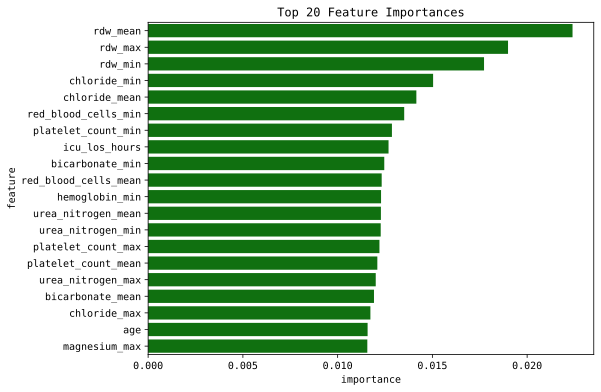

In [12]:
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

np.savez(f'../results/xgboost_fpr_tpr_thresholds.npz', fpr, tpr, thresholds)
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc:.4f}")
_, lower, upper = bootstrap_auc_ci(y_test, y_proba)
print(f"95% CI = [{lower:.4f}, {upper:.4f}]")

importances = final_model.feature_importances_
feat_imp = pd.DataFrame({'feature': X.columns, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(y='feature', x='importance', data=feat_imp, color='green')
plt.title("Top 20 Feature Importances")
plt.show()

No hyperparameter tuning for comparison

In [13]:
default_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric="auc",
    tree_method="hist",         
    random_state=7
)

default_model.fit(X_train_full, y_train_full)
y_pred_def = default_model.predict(X_test)
y_proba_def = default_model.predict_proba(X_test)[:, 1]

roc_auc_def = roc_auc_score(y_test, y_proba_def)
pr_auc_def = average_precision_score(y_test, y_proba_def)

print("Classification Report")
print(classification_report(y_test, y_pred_def))
print(f"ROC-AUC:  {roc_auc_def:.4f}")
print(f"AUPRC:    {pr_auc_def:.4f}")

# Compute CI for AUROC
_, lower_def, upper_def = bootstrap_auc_ci(y_test, y_proba_def)
print(f"95% CI = [{lower_def:.4f}, {upper_def:.4f}]")

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:46:21] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      8164
           1       0.31      0.05      0.09       983

    accuracy                           0.89      9147
   macro avg       0.60      0.52      0.52      9147
weighted avg       0.83      0.89      0.85      9147

ROC-AUC:  0.6867
AUPRC:    0.2080
95% CI = [0.6699, 0.7035]
